<a href="https://colab.research.google.com/github/SANDIEGOAI/MelanomaCV/blob/main/Melanoma_cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Cell 1: Install Libraries & Import Modules
!pip install -q segmentation-models-pytorch
!pip install -q albumentations==1.3.1
!pip install -q torchinfo
!pip install -q grad-cam

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models
import segmentation_models_pytorch as smp
import albumentations as A
import glob
import shutil
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import seaborn as sns

# Setup Device (GPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"✅ Environment Ready! Using Device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
✅ Environment Ready! Using Device: cpu


In [ ]:
# Cell 2: Download & Fix Data
from google.colab import files

# 1. Clean Slate (Remove old data to prevent conflicts)
for folder in ['/content/seg_data', '/content/cls_data']:
    if os.path.exists(folder):
        shutil.rmtree(folder)

# 2. Upload kaggle.json if missing
if not os.path.exists('kaggle.json'):
    print("Please upload your kaggle.json file now...")
    files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("🚀 Downloading Datasets...")

# --- A. SEGMENTATION DATA (ISIC 2016) ---
!kaggle datasets download -d santiagodelrey/isic-2016-task-1-training-data -p /content/seg_data --unzip

# --- B. CLASSIFICATION DATA (ISIC 2019 Resized) ---
!kaggle datasets download -d nischaydnk/isic-2019-jpg-224x224-resized -p /content/cls_data --unzip

# --- C. METADATA FIX (Official CSV) ---
# Force download the correct metadata to fix the "KeyError"
!kaggle datasets download -d andrewmvd/isic-2019 -f ISIC_2019_Training_Metadata.csv -p /content/cls_data --unzip

print("✅ Data Download Complete!")

🚀 Downloading Datasets...
Dataset URL: https://www.kaggle.com/datasets/santiagodelrey/isic-2016-task-1-training-data
License(s): unknown
 98% 591M/601M [00:01<00:00, 340MB/s]
100% 601M/601M [00:01<00:00, 378MB/s]
Dataset URL: https://www.kaggle.com/datasets/nischaydnk/isic-2019-jpg-224x224-resized
License(s): CC0-1.0
100% 354M/355M [00:03<00:00, 65.1MB/s]
100% 355M/355M [00:03<00:00, 96.0MB/s]
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/isic-2019
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
  0% 0.00/172k [00:00<?, ?B/s]
100% 172k/172k [00:00<00:00, 618MB/s]
✅ Data Download Complete!


In [ ]:
# Cell 3: Stage 1 Data Setup
def find_isic2016_folders(base_path):
    img_files = glob.glob(f"{base_path}/**/*.jpg", recursive=True)
    mask_files = glob.glob(f"{base_path}/**/*.png", recursive=True)
    return os.path.dirname(img_files[0]), os.path.dirname(mask_files[0])

SEG_IMG_DIR, SEG_MASK_DIR = find_isic2016_folders('/content/seg_data')

class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self): return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        # ISIC 2016 Mask Naming Logic
        mask_name = img_name.replace('.jpg', '_Segmentation.png')
        mask_path = os.path.join(self.mask_dir, mask_name)

        if not os.path.exists(mask_path): # Fallback
            mask_name = img_name.replace('.jpg', '.png')
            mask_path = os.path.join(self.mask_dir, mask_name)

        image = np.array(Image.open(img_path).convert("RGB"))
        try:
            mask = np.array(Image.open(mask_path).convert("L"))
        except:
            mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

        mask = mask / 255.0
        mask = np.expand_dims(mask, axis=-1)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0
        mask = torch.tensor(mask, dtype=torch.float32).permute(2, 0, 1)
        return image, mask

seg_transform = A.Compose([A.Resize(256, 256), A.HorizontalFlip(p=0.5), A.Rotate(limit=20, p=0.5)])
seg_dataset = SegmentationDataset(SEG_IMG_DIR, SEG_MASK_DIR, seg_transform)
seg_loader = DataLoader(seg_dataset, batch_size=16, shuffle=True)
print(f"✅ Stage 1 Ready: {len(seg_dataset)} segmentation images.")

✅ Stage 1 Ready: 900 segmentation images.


In [ ]:
# Cell 4: Train U-Net
unet_model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=1, activation=None).to(device)
optimizer = torch.optim.Adam(unet_model.parameters(), lr=0.0001)
criterion = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

print("🚀 Training Segmentation Model...")
unet_model.train()
for epoch in range(8): # Train 8 epochs
    total_loss = 0
    for images, masks in seg_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        loss = criterion(unet_model(images), masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Dice Loss: {total_loss/len(seg_loader):.4f}")

# Save
torch.save(unet_model.state_dict(), "unet_model.pth")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

🚀 Training Segmentation Model...
Epoch 1 | Dice Loss: 0.4725
Epoch 2 | Dice Loss: 0.3037
Epoch 3 | Dice Loss: 0.2473
Epoch 4 | Dice Loss: 0.2025
Epoch 5 | Dice Loss: 0.1796
Epoch 6 | Dice Loss: 0.1525
Epoch 7 | Dice Loss: 0.1330
Epoch 8 | Dice Loss: 0.1215


In [ ]:
# Cell 5: Stage 2 Data Setup (Fusion)
# 1. Merge Metadata
print("Merging Metadata...")
df_main = pd.read_csv('/content/cls_data/train-metadata.csv')
# Handle encoding issues automatically
try:
    df_meta = pd.read_csv('/content/cls_data/ISIC_2019_Training_Metadata.csv')
except:
    df_meta = pd.read_csv('/content/cls_data/ISIC_2019_Training_Metadata.csv', encoding='latin1')

df = df_main.merge(df_meta, left_on='isic_id', right_on='image', how='inner')
print(f"Merged Dataset Size: {len(df)}")

# 2. Define Fusion Dataset
class FusionDataset(Dataset):
    def __init__(self, df, img_dir, unet_model=None, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.unet = unet_model

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['isic_id'] + '.jpg'
        img_path = os.path.join(self.img_dir, img_name)

        try:
            image = Image.open(img_path).convert("RGB")
        except:
            return self.__getitem__((idx + 1) % len(self.df))

        # STAGE 1: Apply Segmentation Mask
        if self.unet:
            with torch.no_grad():
                u_in = T.Compose([T.Resize((256, 256)), T.ToTensor()])(image).unsqueeze(0).to(device)
                mask = (self.unet(u_in).sigmoid() > 0.5).float()
                image = T.ToPILImage()( (u_in * mask).squeeze().cpu() )

        # STAGE 2: Metadata Processing
        age = float(row['age_approx']) / 100.0 if pd.notna(row['age_approx']) else 0.5
        sex = 1.0 if row['sex'] == 'female' else 0.0
        site = 1.0 if 'torso' in str(row['anatom_site_general']).lower() else 0.0
        meta = torch.tensor([age, sex, site], dtype=torch.float32)

        label = torch.tensor(row['target'], dtype=torch.float32)
        if self.transform: image = self.transform(image)
        return image, meta, label

CLS_IMG_DIR = '/content/cls_data/train-image/image'
cls_transform = T.Compose([T.Resize((224, 224)), T.ToTensor(), T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

fusion_dataset = FusionDataset(df, CLS_IMG_DIR, unet_model=unet_model, transform=cls_transform)
fusion_loader = DataLoader(fusion_dataset, batch_size=32, shuffle=True)
print("✅ Fusion Dataset Ready!")

Merging Metadata...
Merged Dataset Size: 25331
✅ Fusion Dataset Ready!


In [ ]:
# Cell 6: Train Fusion Model
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(reduction='none')
    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        pt = torch.exp(-bce_loss)
        return (self.alpha * (1 - pt) ** self.gamma * bce_loss).mean()

class MelanomaFusionNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.effnet = models.efficientnet_b0(weights='DEFAULT')
        self.effnet.classifier = nn.Identity()
        self.meta_net = nn.Sequential(nn.Linear(3, 16), nn.ReLU(), nn.Linear(16, 16), nn.ReLU())
        self.classifier = nn.Sequential(nn.Linear(1280 + 16, 128), nn.ReLU(), nn.Dropout(0.4), nn.Linear(128, 1))
    def forward(self, image, meta):
        return self.classifier(torch.cat((self.effnet(image), self.meta_net(meta)), dim=1))

model = MelanomaFusionNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = FocalLoss()

print("🚀 Training Fusion Model (This takes ~15 mins)...")
model.train()
for epoch in range(5):
    total_loss = 0
    for images, meta, labels in fusion_loader:
        images, meta, labels = images.to(device), meta.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = criterion(model(images, meta).squeeze(), labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Focal Loss: {total_loss/len(fusion_loader):.4f}")

🚀 Training Fusion Model (This takes ~15 mins)...
Epoch 1 | Focal Loss: 0.0241
Epoch 2 | Focal Loss: 0.0200
Epoch 3 | Focal Loss: 0.0167
Epoch 4 | Focal Loss: 0.0130
Epoch 5 | Focal Loss: 0.0096


Running Evaluation...
🏆 Final AUC-ROC: 0.9992


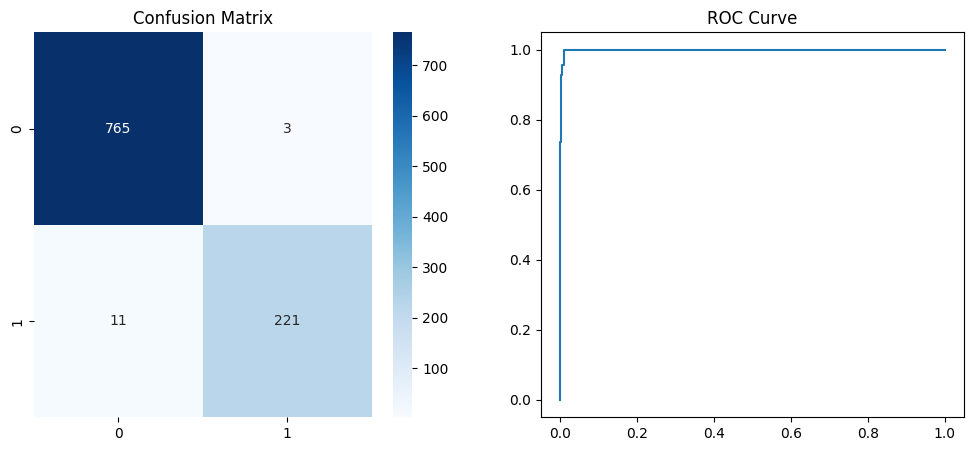

Generating Heatmaps...


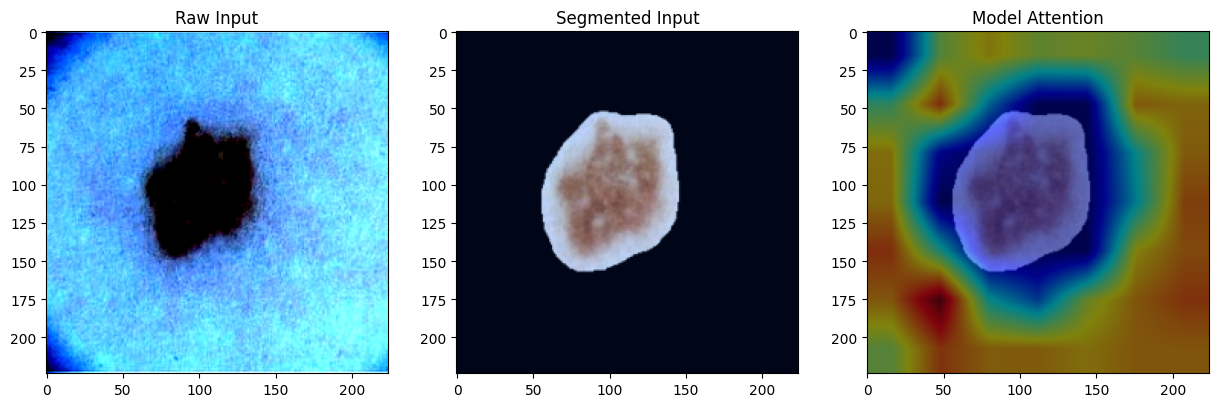

In [ ]:
# Cell 7: Evaluation
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# 1. Metrics
print("Running Evaluation...")
model.eval()
test_loader = DataLoader(FusionDataset(df.iloc[-1000:], CLS_IMG_DIR, unet_model, cls_transform), batch_size=32)
all_preds, all_labels = [], []
with torch.no_grad():
    for img, meta, lbl in test_loader:
        out = model(img.to(device), meta.to(device)).squeeze()
        all_preds.extend(torch.sigmoid(out).cpu().numpy())
        all_labels.extend(lbl.numpy())

roc = roc_auc_score(all_labels, all_preds)
print(f"🏆 Final AUC-ROC: {roc:.4f}")

# 2. Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
cm = confusion_matrix(all_labels, [1 if p > 0.5 else 0 for p in all_preds])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0]); ax[0].set_title("Confusion Matrix")
fpr, tpr, _ = roc_curve(all_labels, all_preds)
ax[1].plot(fpr, tpr); ax[1].set_title("ROC Curve"); plt.show()

# 3. Grad-CAM (Before vs After)
print("Generating Heatmaps...")
class Wrapper(nn.Module):
    def __init__(self, m): super().__init__(); self.m = m
    def forward(self, x): return self.m(x, torch.zeros(x.size(0), 3).to(device))

cam = GradCAM(model=Wrapper(model), target_layers=[model.effnet.features[-1]])
ds_clean = FusionDataset(df, CLS_IMG_DIR, unet_model, cls_transform)
ds_raw = FusionDataset(df, CLS_IMG_DIR, None, cls_transform) # No U-Net

idx = 5 # Sample index
img_clean, _, _ = ds_clean[idx]
img_raw, _, _ = ds_raw[idx]

hm = cam(input_tensor=img_clean.unsqueeze(0).to(device), targets=None)[0, :]
rgb = img_clean.permute(1, 2, 0).cpu().numpy()
rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())
vis = show_cam_on_image(rgb, hm, use_rgb=True)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img_raw.permute(1, 2, 0).cpu().numpy()); ax[0].set_title("Raw Input")
ax[1].imshow(rgb); ax[1].set_title("Segmented Input")
ax[2].imshow(vis); ax[2].set_title("Model Attention")
plt.show()

In [ ]:
# Cell 8: Save to Drive
from google.colab import drive
drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/MelanomaProject/models'
os.makedirs(save_path, exist_ok=True)

torch.save(unet_model.state_dict(), f"{save_path}/stage1_unet.pth")
torch.save(model.state_dict(), f"{save_path}/stage2_fusion.pth")
print(f"✅ Models saved to {save_path}")

Mounted at /content/drive
✅ Models saved to /content/drive/MyDrive/MelanomaProject/models


In [3]:
# 1. Imports
import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision.models as models
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# 2. Setup Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# 3. Re-Define the Fusion Model Architecture (Must match training exactly)
class MelanomaFusionNet(nn.Module):
    def __init__(self):
        super(MelanomaFusionNet, self).__init__()
        # Image Branch
        self.effnet = models.efficientnet_b0(weights=None) # No weights needed, we load ours
        self.effnet.classifier = nn.Identity()
        # Meta Branch
        self.meta_net = nn.Sequential(nn.Linear(3, 16), nn.ReLU(), nn.Linear(16, 16), nn.ReLU())
        # Fusion Head
        self.classifier = nn.Sequential(nn.Linear(1280 + 16, 128), nn.ReLU(), nn.Dropout(0.4), nn.Linear(128, 1))

    def forward(self, image, meta):
        return self.classifier(torch.cat((self.effnet(image), self.meta_net(meta)), dim=1))

print("✅ Model Architectures Defined.")

Using device: cpu
✅ Model Architectures Defined.


In [4]:
from google.colab import drive
import os

# 1. Mount Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 2. Define Paths (Adjust if your folder name is different)
SAVE_PATH = '/content/drive/MyDrive/MelanomaProject/models'
UNET_PATH = os.path.join(SAVE_PATH, 'stage1_unet.pth') # Or 'stage1_unet_final.pth'
FUSION_PATH = os.path.join(SAVE_PATH, 'stage2_fusion.pth') # Or 'stage2_fusion_final.pth'

# 3. Load Stage 1: U-Net
print("Loading U-Net...")
unet = smp.Unet(encoder_name="resnet34", in_channels=3, classes=1, activation=None).to(device)
try:
    unet.load_state_dict(torch.load(UNET_PATH, map_location=device))
    unet.eval() # Set to evaluation mode (freezes dropout/batchnorm)
    print("✅ U-Net Loaded!")
except FileNotFoundError:
    print(f"❌ Error: Could not find {UNET_PATH}. Check your Drive folder.")

# 4. Load Stage 2: Fusion Model
print("Loading Fusion Model...")
model = MelanomaFusionNet().to(device)
try:
    model.load_state_dict(torch.load(FUSION_PATH, map_location=device))
    model.eval()
    print("✅ Fusion Model Loaded!")
except FileNotFoundError:
    print(f"❌ Error: Could not find {FUSION_PATH}. Check your Drive folder.")

Mounted at /content/drive
Loading U-Net...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

✅ U-Net Loaded!
Loading Fusion Model...
✅ Fusion Model Loaded!


In [5]:
def predict_melanoma(image_path, age=50, sex='male', site='torso'):
    """
    Full Pipeline: Raw Image -> U-Net Mask -> Crop -> Fusion Model -> Diagnosis
    """
    # --- PREPROCESS METADATA ---
    # Normalize inputs exactly like training
    age_norm = float(age) / 100.0
    sex_norm = 1.0 if sex.lower() == 'female' else 0.0
    site_norm = 1.0 if site.lower() in ['torso', 'anterior torso', 'posterior torso'] else 0.0

    meta_tensor = torch.tensor([[age_norm, sex_norm, site_norm]], dtype=torch.float32).to(device)

    # --- LOAD IMAGE ---
    try:
        raw_img = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Error opening image: {e}")
        return

    # --- STAGE 1: SEGMENTATION ---
    # Resize to 256 for U-Net
    unet_transform = T.Compose([T.Resize((256, 256)), T.ToTensor()])
    unet_input = unet_transform(raw_img).unsqueeze(0).to(device) # Add batch dim

    with torch.no_grad():
        mask_logits = unet(unet_input)
        mask = (mask_logits.sigmoid() > 0.5).float()

    # Apply Mask (Black out background)
    masked_tensor = unet_input * mask
    masked_pil = T.ToPILImage()(masked_tensor.squeeze().cpu())

    # --- STAGE 2: CLASSIFICATION ---
    # Resize to 224 for EfficientNet + Normalize
    cls_transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    cls_input = cls_transform(masked_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(cls_input, meta_tensor)
        prob = torch.sigmoid(output).item()

    # --- VISUALIZATION ---
    prediction = "MALIGNANT (Cancer)" if prob > 0.5 else "BENIGN (Safe)"
    color = "red" if prob > 0.5 else "green"

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # 1. Raw
    ax[0].imshow(raw_img)
    ax[0].set_title("1. Uploaded Image")
    ax[0].axis('off')

    # 2. Mask (What the U-Net saw)
    ax[1].imshow(mask.squeeze().cpu(), cmap='gray')
    ax[1].set_title("2. Lesion Mask (Stage 1)")
    ax[1].axis('off')

    # 3. Segmented (What the Classifier saw)
    ax[2].imshow(masked_pil)
    ax[2].set_title(f"3. Result: {prediction}\nProbability: {prob:.2%}", color=color, fontsize=12, fontweight='bold')
    ax[2].axis('off')

    plt.show()
    return prob

Upload an image to test (jpg/png)...


Saving test.jpg to test.jpg

Processing test.jpg...


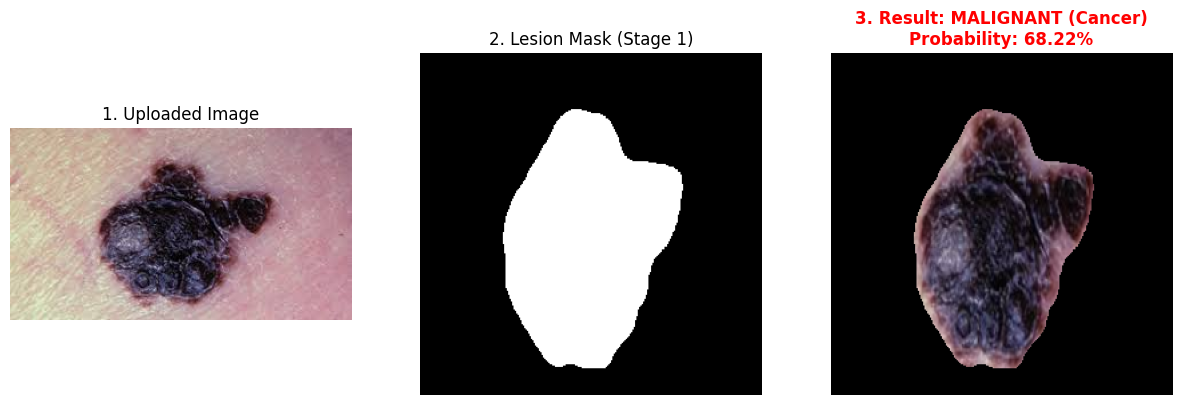

In [6]:
from google.colab import files

print("Upload an image to test (jpg/png)...")
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"\nProcessing {filename}...")

    # Run the Pipeline
    # You can change the patient details here to see how it affects the result!
    predict_melanoma(
        image_path=filename,
        age=45,          # e.g., 45 years old
        sex='male',      # 'male' or 'female'
        site='torso'     # 'torso' or 'other'
    )